## Topics:

- Saving model in local directory
- loading model from local directory

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import torch
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.nn as nn
from utils.helper import fn_plot_confusion_matrix, fn_plot_torch_hist

In [2]:
modelDir = r"C:\Users\DAI.STUDENTSDC\PycharmProjects\pythonProject1\deep learning\day7\models"
subDir = 'fifa_2019'
RANDOM_STATE = 24
np.random.RandomState(seed=RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
rng = np.random.default_rng(seed=RANDOM_STATE)
N_SAMPLE = 1000
ALPHA = 0.001 # LEARNING RATE
TEST_SIZE = 3811 # 18147 - 56*256
EPOCH = 50
BATCH_SIZE = 256
LR_FACTOR = 0.1
LR_PATIENCE = 10

In [3]:
# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'medium',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium',
          'savefig.dpi': 300,
          'image.cmap': plt.cm.inferno,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 2,
          'legend.numpoints' : 1
         }

plt.rcParams.update(params)
# To control the display of floating-point numbers when printing arrays. 
np.set_printoptions(precision=3,  # number of decimal places displayed
                    suppress=True) # prevents the use of scientific notation for small numbers
CMAP = plt.cm.coolwarm
# number of columns displayed when printing a DataFrame
pd.set_option("display.max_columns", 8) # maximum number of columns that will be displayed at once
pd.set_option('display.precision', 2) # precision for floating-point numbers when it’s displayed
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [4]:
# fifa dataset import
data_df = pd.read_csv(r"C:\Users\DAI.STUDENTSDC\PycharmProjects\pythonProject1\deep learning\day4\fifa_2019.csv", index_col=1)
data_df = data_df.drop('Unnamed: 0',axis=1)
data_df

,Name,Age,Photo,Nationality,...,GKKicking,GKPositioning,GKReflexes,Release Clause
ID,,,,,,,,,
158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,...,15.0,14.0,8.0,€226.5M
20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,...,15.0,14.0,11.0,€127.1M
190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,...,15.0,15.0,11.0,€228.1M
193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,...,87.0,88.0,94.0,€138.6M
192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,...,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...
238813,J. Lundstram,19,https://cdn.sofifa.org/players/4/19/238813.png,England,...,7.0,8.0,9.0,€143K
243165,N. Christoffersson,19,https://cdn.sofifa.org/players/4/19/243165.png,Sweden,...,9.0,5.0,12.0,€113K
241638,B. Worman,16,https://cdn.sofifa.org/players/4/19/241638.png,England,...,10.0,6.0,13.0,€165K


In [5]:
with pd.option_context('display.max_columns', None):
    data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18207 entries, 158023 to 246269
Data columns (total 87 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      18207 non-null  object 
 1   Age                       18207 non-null  int64  
 2   Photo                     18207 non-null  object 
 3   Nationality               18207 non-null  object 
 4   Flag                      18207 non-null  object 
 5   Overall                   18207 non-null  int64  
 6   Potential                 18207 non-null  int64  
 7   Club                      17966 non-null  object 
 8   Club Logo                 18207 non-null  object 
 9   Value                     18207 non-null  object 
 10  Wage                      18207 non-null  object 
 11  Special                   18207 non-null  int64  
 12  Preferred Foot            18159 non-null  object 
 13  International Reputation  18159 non-null  float64
 14  Weak 

In [6]:
data_df.isna().sum()

Name                 0
Age                  0
Photo                0
Nationality          0
Flag                 0
                  ... 
GKHandling          48
GKKicking           48
GKPositioning       48
GKReflexes          48
Release Clause    1564
Length: 87, dtype: int64

In [7]:
# removing null values from the 'position' column
data_df.dropna(subset=['Position'], inplace=True)

# Check the 'Position' column
data_df['Position']

ID
158023     RF
20801      ST
190871     LW
193080     GK
192985    RCM
         ... 
238813     CM
243165     ST
241638     ST
246268     RW
246269     CM
Name: Position, Length: 18147, dtype: object

In [8]:
# checking for columns with unique values
for col in data_df.columns:
    unq = data_df[col].unique()
    print(f"{col}, # :{len(unq)}, Values: {unq}")

Name, # :17140, Values: ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']
Age, # :29, Values: [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]
Photo, # :18147, Values: ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']
Nationality, # :164, Values: ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece' 'Chile' 'Sweden' 'Korea Republic' 'Finland' 'Guinea'
 'Montenegro' 'Armenia' 'Switzerland' 'Norway' 'Czech Republic' 'Scotl

In [9]:
# weight col cleaning
data_df['Weight'] = data_df['Weight'].str.replace('lbs','')
data_df['Weight']

ID
158023    159
20801     183
190871    150
193080    168
192985    154
         ... 
238813    134
243165    170
241638    148
246268    154
246269    176
Name: Weight, Length: 18147, dtype: object

In [10]:
# selecting only numeric data features
num_cols = data_df.select_dtypes(exclude='object')
num_cols.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18147 entries, 158023 to 246269
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       18147 non-null  int64  
 1   Overall                   18147 non-null  int64  
 2   Potential                 18147 non-null  int64  
 3   Special                   18147 non-null  int64  
 4   International Reputation  18147 non-null  float64
 5   Weak Foot                 18147 non-null  float64
 6   Skill Moves               18147 non-null  float64
 7   Jersey Number             18147 non-null  float64
 8   Crossing                  18147 non-null  float64
 9   Finishing                 18147 non-null  float64
 10  HeadingAccuracy           18147 non-null  float64
 11  ShortPassing              18147 non-null  float64
 12  Volleys                   18147 non-null  float64
 13  Dribbling                 18147 non-null  float64
 14  Curve

In [11]:
# following columns appear to be relevant for out analysis
rel_cols = ['Position', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 
            'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 
            'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking',
            'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Weight']
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,...,GKKicking,GKPositioning,GKReflexes,Weight
ID,,,,,,,,,
158023,RF,95.0,70.0,90.0,...,15.0,14.0,8.0,159
20801,ST,94.0,89.0,81.0,...,15.0,14.0,11.0,183
190871,LW,87.0,62.0,84.0,...,15.0,15.0,11.0,150
193080,GK,13.0,21.0,50.0,...,87.0,88.0,94.0,168
192985,RCM,82.0,55.0,92.0,...,5.0,10.0,13.0,154


In [12]:
data_df['Weight']  = pd.to_numeric(data_df['Weight'])
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18147 entries, 158023 to 246269
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Position         18147 non-null  object 
 1   Finishing        18147 non-null  float64
 2   HeadingAccuracy  18147 non-null  float64
 3   ShortPassing     18147 non-null  float64
 4   Volleys          18147 non-null  float64
 5   Dribbling        18147 non-null  float64
 6   Curve            18147 non-null  float64
 7   FKAccuracy       18147 non-null  float64
 8   LongPassing      18147 non-null  float64
 9   BallControl      18147 non-null  float64
 10  Acceleration     18147 non-null  float64
 11  SprintSpeed      18147 non-null  float64
 12  Agility          18147 non-null  float64
 13  Reactions        18147 non-null  float64
 14  Balance          18147 non-null  float64
 15  ShotPower        18147 non-null  float64
 16  Jumping          18147 non-null  float64
 17  Stamina    

C:\Users\dai\AppData\Local\Temp\ipykernel_22020\2970836287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['Weight']  = pd.to_numeric(data_df['Weight'])


In [13]:
# checking for missing values in the data
data_df.isna().sum().sum()

np.int64(0)

In [14]:
data_df['Position'].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

In [15]:
# we want to classify only within four classes
goalkeeper = 'GK'
forward = ['ST', 'LS', 'RS', 'LW', 'RW', 'LF', 'RF', 'CF']
midfielder = ['LDM', 'CAM', 'CDM', 'RAM', 'RCM', 'CM', 'RDM', 'LAM', 'LM', 'RM', 'LCM']
defender = ['RB', 'CB', 'LB', 'RWB', 'LWB', 'RCB', 'LCB']

In [16]:
# encoding the positions accordingly
data_df.loc[data_df['Position'] == 'GK', 'Position'] = 0
data_df.loc[data_df['Position'].isin(defender), 'Position'] = 1
data_df.loc[data_df['Position'].isin(midfielder), 'Position'] = 2
data_df.loc[data_df['Position'].isin(forward), 'Position'] = 3

In [17]:
# converting the position column to a numerical data type from object format
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast='integer')

C:\Users\dai\AppData\Local\Temp\ipykernel_22020\2328605209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['Position'] = pd.to_numeric(data_df['Position'], downcast='integer')


In [18]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18147 entries, 158023 to 246269
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Position         18147 non-null  int8   
 1   Finishing        18147 non-null  float64
 2   HeadingAccuracy  18147 non-null  float64
 3   ShortPassing     18147 non-null  float64
 4   Volleys          18147 non-null  float64
 5   Dribbling        18147 non-null  float64
 6   Curve            18147 non-null  float64
 7   FKAccuracy       18147 non-null  float64
 8   LongPassing      18147 non-null  float64
 9   BallControl      18147 non-null  float64
 10  Acceleration     18147 non-null  float64
 11  SprintSpeed      18147 non-null  float64
 12  Agility          18147 non-null  float64
 13  Reactions        18147 non-null  float64
 14  Balance          18147 non-null  float64
 15  ShotPower        18147 non-null  float64
 16  Jumping          18147 non-null  float64
 17  Stamina    

In [19]:
data_df.dropna(axis=1, inplace=True)
class_labels = {0:'Goalkeeper', 1:'Defender', 2:'Midfielder', 3:'Forward'}

C:\Users\dai\AppData\Local\Temp\ipykernel_22020\1525783634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.dropna(axis=1, inplace=True)


In [20]:
X = data_df.drop('Position', axis=1)
y = data_df['Position'].to_numpy()
X

,Finishing,HeadingAccuracy,ShortPassing,Volleys,...,GKKicking,GKPositioning,GKReflexes,Weight
ID,,,,,,,,,
158023,95.0,70.0,90.0,86.0,...,15.0,14.0,8.0,159
20801,94.0,89.0,81.0,87.0,...,15.0,14.0,11.0,183
190871,87.0,62.0,84.0,84.0,...,15.0,15.0,11.0,150
193080,13.0,21.0,50.0,13.0,...,87.0,88.0,94.0,168
192985,82.0,55.0,92.0,82.0,...,5.0,10.0,13.0,154
...,...,...,...,...,...,...,...,...,...
238813,38.0,40.0,49.0,25.0,...,7.0,8.0,9.0,134
243165,52.0,52.0,43.0,36.0,...,9.0,5.0,12.0,170
241638,40.0,46.0,38.0,38.0,...,10.0,6.0,13.0,148


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
display(X_train.describe())
X_train.shape, y_train.shape, X_test.shape, y_test.shape

,Finishing,HeadingAccuracy,ShortPassing,Volleys,...,GKKicking,GKPositioning,GKReflexes,Weight
count,14336.00,14336.00,14336.00,14336.00,...,14336.00,14336.00,14336.00,14336.00
mean,45.53,52.25,58.69,42.90,...,16.21,16.37,16.71,165.99
std,19.53,17.39,14.71,17.73,...,16.47,16.98,17.93,15.61
min,2.00,4.00,7.00,4.00,...,1.00,1.00,1.00,110.00
25%,30.00,44.00,54.00,30.00,...,8.00,8.00,8.00,154.00
50%,49.00,55.00,62.00,44.00,...,11.00,11.00,11.00,165.00
75%,62.00,64.00,68.00,57.00,...,14.00,14.00,14.00,176.00
max,95.00,94.00,93.00,90.00,...,91.00,90.00,94.00,243.00


((14336, 34), (14336,), (3811, 34), (3811,))

In [22]:
# scaling the data first before training, since the central tendencies of the features are all over the place
from sklearn.preprocessing import StandardScaler
scl_std = StandardScaler()
X_train = scl_std.fit_transform(X_train)
X_test = scl_std.transform(X_test)
X_train.shape

(14336, 34)

In [23]:
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [24]:
# pytorch model setup(Class based setup)
input_dim = X_train.shape[1]

# instantiate the model as a class
class Model(nn.Module): # subclass of nn.Module superclass from pytorch
    ## first do it normally, then do it with dropouts and batch Normalization
    def __init__(self,input_dim):
        super(Model,self).__init__() # calls initializer of nn.Module
        dor1 = 0.1

        self.layer1 = nn.Linear(input_dim, 18)
        self.actv1 = nn.ReLU()

        self.do1 = nn.Dropout(dor1) # dropout
        self.bnl = nn.BatchNorm1d(18)

        self.layer2 = nn.Linear(18,4)
    def forward(self, x):
        # forward chaining
        # set 1
        # this order of chaining should be maintained
        x = self.layer1(x)
        x = self.bnl(x)
        x = self.actv1(x)
        x = self.do1(x)
        # set 2
        x = self.layer2(x)
        return x
    
model = Model(input_dim).to(device=device)
model

Model(
  (layer1): Linear(in_features=34, out_features=18, bias=True)
  (actv1): ReLU()
  (do1): Dropout(p=0.1, inplace=False)
  (bnl): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=18, out_features=4, bias=True)
)

In [25]:
for param in list(model.parameters()):
    display(param.shape)

torch.Size([18, 34])

torch.Size([18])

torch.Size([18])

torch.Size([18])

torch.Size([4, 18])

torch.Size([4])

### Without Custom Dataset

In [26]:
# # numpy array to tensor conversion. These tensors are then moved to the the device mentioned above
# train_X = torch.tensor(X_train, dtype=torch.float32, device=device) # these datatypes are the standard for such conversions
# train_y = torch.tensor(y_train, dtype=torch.int64, device=device)
# test_X = torch.tensor(X_test, dtype=torch.float32, device=device)
# test_y = torch.tensor(y_test, dtype=torch.int64, device=device)


In [27]:
# # optimizer in pytorch
# torch.optim.RMSprop?

In [28]:
# # loss function definition and training the model
# # this is the model.compile equivalent of tf
# loss_fn = nn.CrossEntropyLoss()
# # setting up the optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)
# # some lists to collect progress
# loss = []
# tloss = []
# n_epoch = []
# acc = []
# tacc = []

# # this part is the model.fit equivalent of tf
# # loop to define epochs
# for epoch in range(EPOCH):
#     model.train() # setting your model to train mode. Using the train dataset here
#     predict_proba = model(train_X) # make predictions
#     curr_loss = loss_fn(predict_proba, train_y) # calculate loss
#     # backpropagation
#     optimizer.zero_grad() # deletes any previous gradients which are accumulated from the previous loops
#     curr_loss.backward() # backward pass. Computes the gradients that populate the .grad attribute of the parameters
#     optimizer.step() # updates the models parameters

#     loss.append(curr_loss.data.item())
#     y_pred = torch.argmax(predict_proba, 1).cpu().numpy()
#     curr_acc = accuracy_score(train_y.cpu().numpy(), y_pred.data)
#     acc.append(curr_acc)

#     model.eval() # setting the model to eval mode. Using the validation(test) dataset here
#     test_proba = model(test_X)  # make predictions
#     test_loss = loss_fn(test_proba, test_y) # calculate the loss
#     tloss.append(test_loss.data.item()) # append for plotting

#     y_pred = torch.argmax(test_proba, dim=1).cpu().numpy()
#     test_acc = accuracy_score(test_y.cpu().numpy(), y_pred.data.item())
#     tacc. append(test_acc)
#     n_epoch.append(epoch)

#     print(f'Epoch {epoch+1}/{EPOCH}, Loss: {curr_loss.item()}, Accuracy: {curr_acc} / {test_acc}')

In [29]:
# # Loss and optimizer setup
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)

# # Metrics tracking
# loss, tloss, acc, tacc, n_epoch = [], [], [], [], []
# optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_FACTOR, patience =LR_PATIENCE)

# # Training loop
# for epoch in range(EPOCH):
#     # Training phase
#     model.train()
#     predict_proba = model(train_X) # make predictions
#     curr_loss = loss_fn(predict_proba, train_y) # calculate loss

#     # Backpropagation phase
#     optimizer.zero_grad(set_to_none=True)  # Clear gradients
#     curr_loss.backward()  # Backpropagation. Calculate Loss gradient
#     optimizer.step()  # Update parameters

#     loss.append(curr_loss.item())  # Store training loss
#     y_pred = torch.argmax(predict_proba, dim=1).cpu().numpy()
#     curr_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
#     acc.append(curr_acc)  # Store training accuracy

#     # Validation phase
#     model.eval()
#     with torch.no_grad():  # Disable gradient computation
#         test_proba = model(test_X)
#         test_loss = loss_fn(test_proba, test_y)
#         tloss.append(test_loss.item())  # Store validation loss

#         y_pred = torch.argmax(test_proba, dim=1).cpu().numpy()
#         test_acc = accuracy_score(test_y.cpu().numpy(), y_pred)
#         tacc.append(test_acc)  # Store validation accuracy

#     n_epoch.append(epoch)
#     # LR Reductions step
#     scheduler.step(test_loss)

# # Logging progress

# if epoch %10 == 0:
#     print(f"Epoch {epoch + 1}/{EPOCH}, Loss: {curr_loss.item():.4f}, "
#           f"Train Acc: {curr_acc:.4f}, Test Acc: {test_acc:.4f}")
#     print(f'LR: {scheduler.get_last_lr()}')


In [30]:
# hist_df = pd.DataFrame({'epoch':n_epoch,
#                        'loss':loss, 
#                        'test_loss':tloss,
#                        'acc':acc,
#                        'test_acc':tacc})
# hist_df

In [31]:
# hist_df.plot(x='epoch', y=['loss', 'test_loss', 'acc', 'test_acc'])

In [32]:
# fn_plot_torch_hist(hist_df=hist_df)

In [33]:
# # performance on train data
# outputs = model(train_X) # this is a tensor 
# outputs.cpu().detach().numpy() # The .detach() method in PyTorch is used to create a new tensor that shares the same data as the original tensor but without requiring gradients.

In [34]:
# y_pred = torch.argmax(outputs, dim=1).cpu().numpy() # tensor input and conversion to numpy
# y_pred

In [35]:
# y_true = train_y.cpu().numpy()
# print(classification_report(y_true, y_pred))

In [36]:
# # confusion matrix
# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(cm, display_labels=class_labels.values())
# disp.plot(cmap='Blues', xticks_rotation='vertical', colorbar=False)
# plt.grid(False)

### With Custom dataset

In [37]:
# conversion to torch custom dataset
class FifaDataset(Dataset):
    def __init__(self, X, y):
        super(FifaDataset,self).__init__() # initializes the constructor of the superclass of FifaDataset ==> (Dataset)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self): # returns the number of rows in the dataset
        return len(self.X)

    def __getitem__(self,idx): # getting the indices of the item in the dataset
        return self.X[idx], self.y[idx]    


In [38]:
# training data to custom dataset
train_dataset = FifaDataset(X_train, y_train)
train_dataset

In [39]:
# using DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
X_batch, y_batch = next(iter(train_loader))
X_batch.shape, y_batch.shape

(torch.Size([256, 34]), torch.Size([256]))

In [40]:
# testing data to custom dataset
test_dataset = FifaDataset(X_test, y_test)
test_dataset

In [41]:
# DataLoader in PyTorch is a utility provided in the torch.utils.data module to efficiently load and iterate over datasets in mini-batches.
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True) 
X_batch, y_batch = next(iter(test_loader))
X_batch.shape, y_batch.shape

(torch.Size([256, 34]), torch.Size([256]))

In [42]:
# Model training and fitting, with batches
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_FACTOR, patience =LR_PATIENCE)
# Metrics tracking
loss, tloss, acc, tacc, n_epoch = [], [], [], [], []
best_loss = np.inf

# Training loop
# for epoch in range(300):
for epoch in range(EPOCH):
    epoch_loss = 0
    epoch_acc = 0
    tepoch_loss = 0
    tepoch_acc = 0 
    # Training phase
    model.train()
    for batch_idx , (train_X, train_y) in enumerate(train_loader):
        train_X = train_X.to(device)
        train_y = train_y.to(device)
        predict_proba = model(train_X) # make predictions
        batch_loss = loss_fn(predict_proba, train_y) # calculate batch loss
        epoch_loss += (batch_loss - epoch_loss)/(batch_idx+1) # average of batch losses till now(running)

        # Backpropagation phase
        optimizer.zero_grad(set_to_none=True)  # Clear gradients
        batch_loss.backward()  # Calculate Loss gradient and propagate it backwards
        optimizer.step()  # Update parameters

        y_pred = predict_proba.argmax(dim=1).cpu().numpy()
        batch_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
        epoch_acc += (batch_acc - epoch_acc)/(batch_idx+1) # average of batch accuracies till now
    

    loss.append(epoch_loss.data.item())  # Store training loss for this epoch
    acc.append(epoch_acc)  # Store training accuracy for this epoch

    # Validation phase
    model.eval()
    for batch_idx, (test_X, test_y) in enumerate(test_loader):
        with torch.no_grad():  # Disable gradient computation
            test_X = test_X.to(device)
            test_y = test_y.to(device)
            test_proba = model(test_X) # make a prediction
            batch_loss = loss_fn(test_proba, test_y) # calculate loss
            tepoch_loss += (batch_loss - tepoch_loss)/(batch_idx+1)  # average of batch losses till now

            y_pred = test_proba.argmax(dim=1).cpu().numpy()
            batch_acc = accuracy_score(test_y.cpu().numpy(), y_pred)
            tepoch_acc += (batch_acc - tepoch_acc)/(batch_idx+1) # Running mean of accuracies
    
    tacc.append(tepoch_acc)
    tloss.append(tepoch_loss.data.item()) # picking out the item from the data in the tensor
    n_epoch.append(epoch) # appending epoch numbers
    scheduler.step(tepoch_loss)
    # Logging progress
    print(f"Epoch {epoch + 1}/{EPOCH}, Loss: {epoch_loss:.4f}/{tepoch_loss:.4f}, "
          f"Acc: {epoch_acc:.4f}/{tepoch_acc:.4f}")


Epoch 1/50, Loss: 1.1180/0.8645, Acc: 0.5865/0.7801
Epoch 2/50, Loss: 0.7343/0.6087, Acc: 0.7923/0.8146
Epoch 3/50, Loss: 0.5473/0.4752, Acc: 0.8248/0.8313
Epoch 4/50, Loss: 0.4506/0.4048, Acc: 0.8458/0.8472
Epoch 5/50, Loss: 0.3996/0.3700, Acc: 0.8547/0.8546
Epoch 6/50, Loss: 0.3762/0.3521, Acc: 0.8571/0.8588
Epoch 7/50, Loss: 0.3600/0.3404, Acc: 0.8610/0.8594
Epoch 8/50, Loss: 0.3481/0.3325, Acc: 0.8625/0.8640
Epoch 9/50, Loss: 0.3419/0.3279, Acc: 0.8635/0.8653
Epoch 10/50, Loss: 0.3356/0.3226, Acc: 0.8643/0.8665
Epoch 11/50, Loss: 0.3308/0.3192, Acc: 0.8670/0.8682
Epoch 12/50, Loss: 0.3262/0.3169, Acc: 0.8668/0.8684
Epoch 13/50, Loss: 0.3251/0.3130, Acc: 0.8666/0.8694
Epoch 14/50, Loss: 0.3220/0.3111, Acc: 0.8693/0.8715
Epoch 15/50, Loss: 0.3173/0.3092, Acc: 0.8701/0.8682
Epoch 16/50, Loss: 0.3155/0.3086, Acc: 0.8721/0.8706
Epoch 17/50, Loss: 0.3158/0.3073, Acc: 0.8707/0.8684
Epoch 18/50, Loss: 0.3118/0.3056, Acc: 0.8731/0.8691
Epoch 19/50, Loss: 0.3102/0.3045, Acc: 0.8712/0.8692
Ep

In [44]:
tepoch_loss, best_loss

(tensor(0.2983), inf)

In [45]:
# Saving model
if tepoch_loss <= best_loss:
    best_loss = tepoch_loss
    torch.save(model, modelPath)

In [46]:
hist_df = pd.DataFrame({'epoch':n_epoch,
                       'loss':loss, 
                       'test_loss':tloss,
                       'acc':acc,
                       'test_acc':tacc})
hist_df

,epoch,loss,test_loss,acc,test_acc
0,0,1.12,0.86,0.59,0.78
1,1,0.73,0.61,0.79,0.81
2,2,0.55,0.48,0.82,0.83
3,3,0.45,0.40,0.85,0.85
4,4,0.40,0.37,0.85,0.85
5,5,0.38,0.35,0.86,0.86
6,6,0.36,0.34,0.86,0.86
7,7,0.35,0.33,0.86,0.86
8,8,0.34,0.33,0.86,0.87
9,9,0.34,0.32,0.86,0.87


<Axes: xlabel='epoch'>

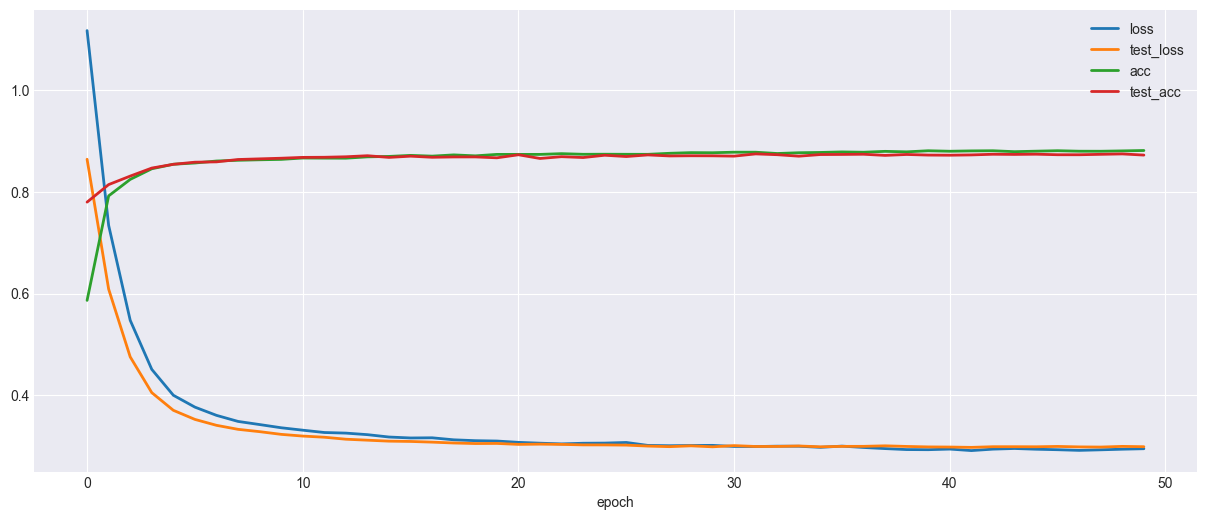

In [47]:
hist_df.plot(x='epoch', y=['loss', 'test_loss', 'acc', 'test_acc'])

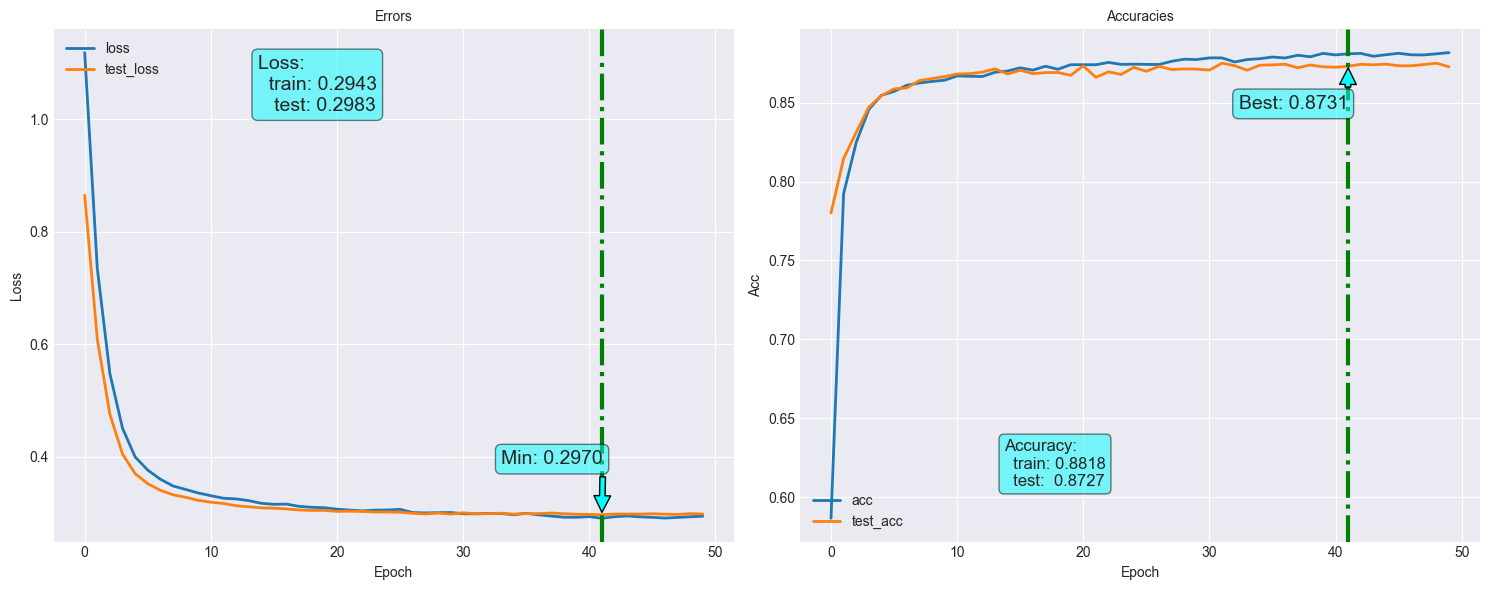

In [48]:
fn_plot_torch_hist(hist_df)

In [ ]:
# Assuming model is your trained model
modelPath = os.path.join(modelDir, subDir, f'torch_{subDir}_{torch.version.cuda}.pth')
torch.save(model, modelPath)


In [ ]:
print(f'Saved file as: {modelPath}')

Saved file in: C:\Users\DAI.STUDENTSDC\PycharmProjects\pythonProject1\deep learning\day7\models\fifa_2019\torch_fifaNone.pth


In [51]:
del model

In [ ]:
# Loading model 
model = torch.load(modelPath, weights_only=False)
model.eval()

Model(
  (layer1): Linear(in_features=34, out_features=18, bias=True)
  (actv1): ReLU()
  (do1): Dropout(p=0.1, inplace=False)
  (bnl): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=18, out_features=4, bias=True)
)